In [1]:
import pandas as pd
train_df = pd.read_csv(r'train.csv')
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [2]:
train_right_df = train_df[train_df["target"]==1]
train_wrong_df = train_df[train_df["target"]==0]
train_right_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## Hipóteses
- O tamanho dos tweets infuenciam
- Número de palavras no tweet influenciam
- As palavras mais repetidas são influentes

In [3]:
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
import matplotlib.pyplot as plt

train_right_words_df = []
train_wrong_words_df = []

## let's get counts for the first 5 tweets in the data
for index, row in train_right_df.iterrows():
    train_right_words_df.append(len(row["text"].split()))

(array([ 41., 174., 425., 625., 418., 711., 510., 272.,  83.,  12.]),
 array([ 2. ,  4.8,  7.6, 10.4, 13.2, 16. , 18.8, 21.6, 24.4, 27.2, 30. ]),
 <BarContainer object of 10 artists>)

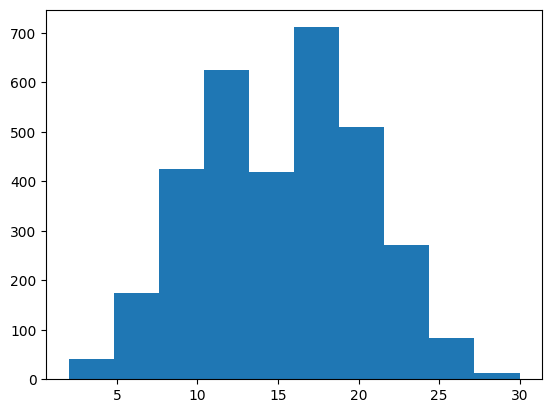

In [4]:
plt.hist(train_right_words_df)

(array([100., 345., 539., 690., 684., 728., 585., 416., 204.,  51.]),
 array([ 1.,  4.,  7., 10., 13., 16., 19., 22., 25., 28., 31.]),
 <BarContainer object of 10 artists>)

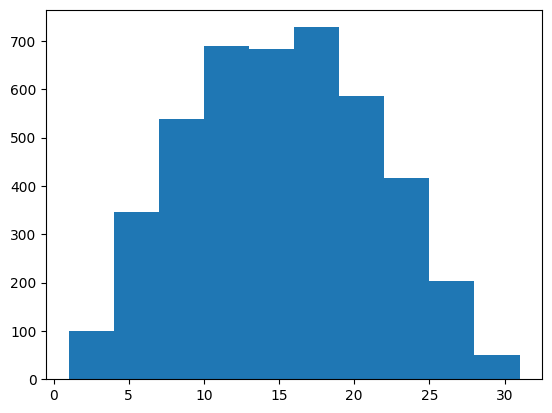

In [5]:
for index, row in train_wrong_df.iterrows():
    train_wrong_words_df.append(len(row["text"].split()))
plt.hist(train_wrong_words_df)

In [6]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score

# Assuming train_df is your DataFrame and it has columns "text" and "target"

# Calculate count of words
train_df["count_words"] = train_df["text"].apply(lambda x: len(x.split()))

# Split the data
X_train, X_test, y_train, y_test = train_test_split(train_df[["count_words"]], train_df["target"], test_size=0.2, random_state=42)

# Instantiate the linear regression model
model = LinearRegression()

# Train the model on the training data
model.fit(X_train, y_train)

# Predict on the testing data
y_pred = model.predict(X_test)

# Set the threshold
threshold = 0.5

# Classify predictions
y_pred_discrete = (y_pred > threshold).astype(int)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_discrete)
print("Accuracy:", accuracy)


Accuracy: 0.5738673670387393


In [8]:
test_df = pd.read_csv(r'test.csv')
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [9]:
test_df["count_words"] = test_df["text"].apply(lambda x: len(x.split()))

# Predict the target variable using the trained model
test_df["target"] = model.predict(test_df[["count_words"]])

# Set the threshold
threshold = 0.5

# Classify predictions
test_df["target"] = (test_df["target"] > threshold).astype(int)


In [11]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
import torch
import pandas as pd

# Carregando o modelo e o tokenizer
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Function for cleaning tweets
def clean_tweet(tweet):
    tweet_words = []
    for word in tweet.split():
        if word.startswith('@') and len(word) > 1:
            word = '@user'
        elif word.startswith('http') and len(word) > 1:
            word = 'http'
        tweet_words.append(word)
    return " ".join(tweet_words)

# Function for performing inference
def classify_tweets(tweets):
    encoded_inputs = tokenizer(tweets, return_tensors='pt', padding=True, truncation=True)
    outputs = model(**encoded_inputs)
    scores = softmax(outputs.logits.detach().numpy(), axis=1)
    return scores


# Load your data into train_df

# Clean tweets
train_df['text_clean'] = train_df['text'].apply(clean_tweet)

# Batch processing
batch_size = 32
sentiment_scores_list = []
for i in range(0, len(train_df), batch_size):
    batch_tweets = train_df['text_clean'][i:i+batch_size].tolist()
    scores = classify_tweets(batch_tweets)
    sentiment_scores_list.extend(scores)

# Add sentiment scores to the original DataFrame
sentiment_df = pd.DataFrame(sentiment_scores_list, columns=['negative_score', 'neutral_score', 'positive_score'])
result_df = pd.concat([train_df.reset_index(drop=True), sentiment_df.reset_index(drop=True)], axis=1)

# Write result to CSV
result_df.to_csv(r'result.csv', index=False)

c:\Users\guibe\anaconda3\envs\kaggle_project\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [21]:
train_df = pd.read_csv(r'result.csv')

train_df['max_column'] = train_df[['negative_score', 'neutral_score', 'positive_score']].idxmax(axis=1)

train_df.drop(columns=['negative_score', 'neutral_score', 'positive_score'], inplace=True)

In [31]:
train_df.head()

,id,keyword,location,text,target,count_words,text_clean,max_column
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,13,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,7,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,22,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,8,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,16,Just got sent this photo from Ruby #Alaska as ...,0


In [41]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Assuming X is your feature matrix and y is your target vector (containing 0s and 1s)
# Splitting the data into training and testing sets

# Assuming your DataFrame is named train_df

train_df['max_column'].replace({'neutral_score': 1, 'negative_score': 0, 'other_value': 2}, inplace=True)
train_df['max_column'] = pd.to_numeric(train_df['max_column'], errors='coerce')

train_df.dropna(inplace=True)

combined_features = pd.concat([train_df['max_column'], train_df['count_words']], axis=1)


X_train, X_test, y_train, y_test = train_test_split(combined_features, train_df['target'], test_size=0.17, random_state=42)


# Creating a logistic regression model
model = LogisticRegression()

# Fitting the model to the training data
model.fit(X_train, y_train)

# Making predictions on the testing data
predictions = model.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

# Printing classification report
print(classification_report(y_test, predictions))


Accuracy: 0.5602094240837696
              precision    recall  f1-score   support

           0       0.59      0.61      0.60       412
           1       0.52      0.50      0.51       352

    accuracy                           0.56       764
   macro avg       0.56      0.56      0.56       764
weighted avg       0.56      0.56      0.56       764



C:\Users\guibe\AppData\Local\Temp\ipykernel_1104\421947618.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['max_column'].replace({'neutral_score': 1, 'negative_score': 0, 'other_value': 2}, inplace=True)


In [44]:
# Clean tweets

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
import torch
import pandas as pd

# Carregando o modelo e o tokenizer
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Function for cleaning tweets
def clean_tweet(tweet):
    tweet_words = []
    for word in tweet.split():
        if word.startswith('@') and len(word) > 1:
            word = '@user'
        elif word.startswith('http') and len(word) > 1:
            word = 'http'
        tweet_words.append(word)
    return " ".join(tweet_words)

# Function for performing inference
def classify_tweets(tweets):
    encoded_inputs = tokenizer(tweets, return_tensors='pt', padding=True, truncation=True)
    outputs = model(**encoded_inputs)
    scores = softmax(outputs.logits.detach().numpy(), axis=1)
    return scores

test_df = pd.read_csv(r'test.csv')

test_df["count_words"] = test_df["text"].apply(lambda x: len(x.split()))

test_df['text_clean'] = test_df['text'].apply(clean_tweet)

# Batch processing
batch_size = 32
sentiment_scores_list = []
for i in range(0, len(test_df), batch_size):
    batch_tweets = test_df['text_clean'][i:i+batch_size].tolist()
    scores = classify_tweets(batch_tweets)
    sentiment_scores_list.extend(scores)

# Add sentiment scores to the original DataFrame
sentiment_df = pd.DataFrame(sentiment_scores_list, columns=['negative_score', 'neutral_score', 'positive_score'])
result_df = pd.concat([test_df.reset_index(drop=True), sentiment_df.reset_index(drop=True)], axis=1)




c:\Users\guibe\anaconda3\envs\kaggle_project\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


KeyboardInterrupt: 

In [ ]:
model.fit(X_train, y_train)

# Making predictions on the testing data
predictions = model.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

# Printing classification report
print(classification_report(y_test, predictions))

In [ ]:
submission = result_df[["id","target"]]
submission.to_csv(r'submission.csv',index=False)

In [ ]:
import kaggle

# Replace 'submission.csv' with the path to your submission file
submission_file = 'submission.csv'

# Replace 'Message' with your submission message
submission_message = 'First try'

# Call the submit function from kaggle package
#kaggle.api.competition_submit(submission_file, submission_message, competition='nlp-getting-started')


ModuleNotFoundError: No module named 'kaggle'